In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.mixture import GaussianMixture
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score
from sklearn.decomposition import PCA


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Carregando os dados
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/trabalho-final-AM/dataset/enron_spam_data.csv')
df['text'] = df['Subject'].fillna('') + ' ' + df['Message'].fillna('')
df = df.drop_duplicates(keep='first')

In [5]:
X = df['text']
y = df['Spam/Ham']

In [6]:
df.head()

,Message ID,Subject,Message,Spam/Ham,Date,text
0,0,christmas tree farm pictures,NaN,ham,1999-12-10,christmas tree farm pictures
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13,"vastar resources , inc . gary , production fro..."
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14,calpine daily gas nomination - calpine daily g...
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,1999-12-14,re : issue fyi - see note below - already done...
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14,meter 7268 nov allocation fyi .\n- - - - - - -...


In [7]:
X.shape

(33716,)

In [8]:
y.shape

(33716,)

In [9]:
# Separando treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Selecionando apenas as mensagens 'ham' para treinamento
X_train_ham = X_train[y_train == 'ham']

X_train_ham.shape

(13236,)

In [10]:
X_test

,text
7998,"total return swap hi , vince ,\nplease see att..."
23877,re : metals - imminent actions - an update ric...
19753,"generic vioxx , generic ambien , generic nexiu..."
22613,president ' s day holiday due to the president...
10211,be one of our survey takers and we ' ll send y...
...,...
1496,re : discrepancies in price of gas redelivered...
24427,"re : your bank account dear\nfriend , a recent..."
21128,your girifriend needs to be strong chronic pai...
24422,"muscles , money , and looks help - but women w..."


In [11]:
# Transformação TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=500)
X_train_ham_tfidf = vectorizer.fit_transform(X_train_ham)
X_test_tfidf = vectorizer.transform(X_test)


In [12]:
X_test_tfidf.shape

(6744, 500)

In [13]:
# Treinamento do GMM
gmm = GaussianMixture(n_components=10, covariance_type='tied', random_state=42)
gmm.fit(X_train_ham_tfidf.toarray())


GaussianMixture(covariance_type='tied', n_components=10, random_state=42)

In [14]:
# Detecção de Anomalias nos dados de teste
log_likelihood = gmm.score_samples(X_train_ham_tfidf.toarray())
log_likelihood_teste = gmm.score_samples(X_test_tfidf.toarray())


In [15]:
log_likelihood_teste_negativo = -log_likelihood_teste
print(log_likelihood_teste_negativo)

[ -884.43479792 -1021.47515195 -1221.62609186 ...  -886.75023087
  -674.35287218 -1012.48093326]


In [16]:
y_test_bin = np.where(y_test == 'spam', 1, 0)

fpr, tpr, thresholds = roc_curve(y_test_bin, log_likelihood_teste_negativo)

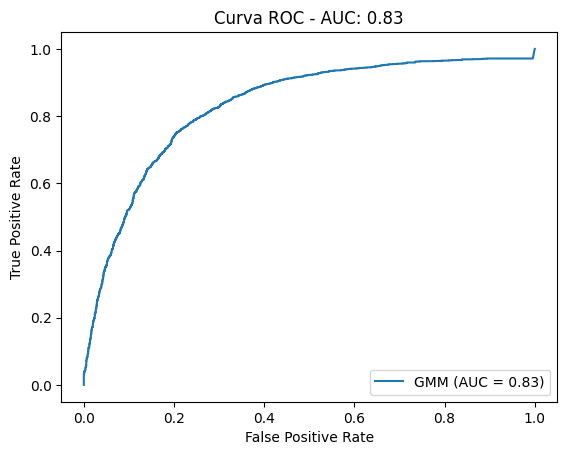

In [17]:
# Calculando a AUC
roc_auc = roc_auc_score(y_test_bin, log_likelihood_teste_negativo)

# Plotando a curva ROC
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='GMM')
roc_display.plot()


plt.title(f'Curva ROC - AUC: {roc_auc:.2f}')
plt.show()

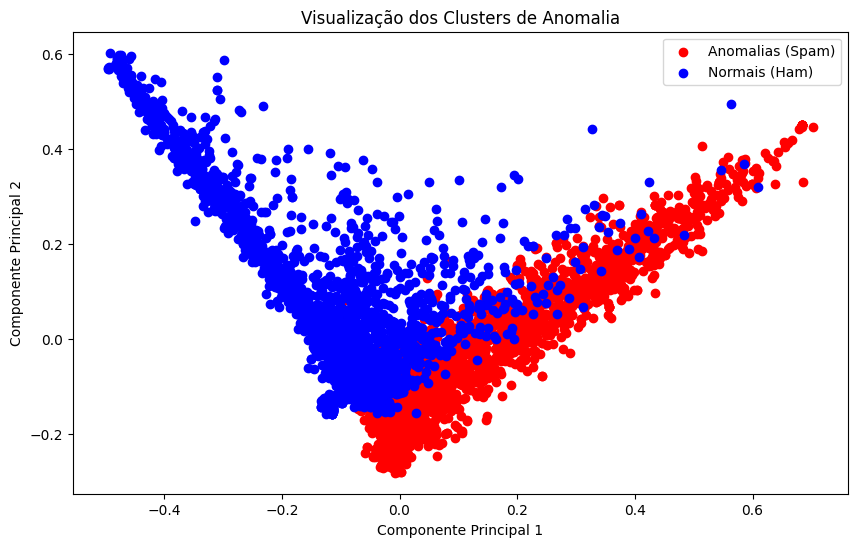

In [18]:
# Visualização dos grupos formados

# Reduzindo a dimensionalidade para 2D
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_tfidf.toarray())

# Convert y_test para array booleano onde verdadeiro representa 'spam'
spam_indices = y_test == 'spam'

plt.figure(figsize=(10, 6))
plt.scatter(X_test_pca[spam_indices, 0], X_test_pca[spam_indices, 1], color='red', label='Anomalias (Spam)')
plt.scatter(X_test_pca[~spam_indices, 0], X_test_pca[~spam_indices, 1], color='blue', label='Normais (Ham)')
plt.title('Visualização dos Clusters de Anomalia')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.show()


In [19]:
from sklearn.metrics import precision_recall_fscore_support

best_f1 = 0
best_threshold = 0
for threshold in np.linspace(min(log_likelihood_teste_negativo), max(log_likelihood_teste_negativo), 100):
    y_pred = np.where(log_likelihood_teste_negativo > threshold, 1, 0)
    precisao, recall, f1, _ = precision_recall_fscore_support(y_test_bin, y_pred, average='binary')

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best F1: {best_f1:.2f} with threshold: {best_threshold:.2f}")


Best F1: 0.75 with threshold: -879.93


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

threshold = best_threshold

# Classificação binária com base no limiar
y_pred = np.where(log_likelihood_teste_negativo  > threshold, 1, 0)  # 1 para 'spam', 0 para 'ham'

# Cálculo das métricas
acuracia = accuracy_score(y_test_bin, y_pred)
precisao = precision_score(y_test_bin, y_pred)
recall = recall_score(y_test_bin, y_pred)
f1 = f1_score(y_test_bin, y_pred)

# Exibição dos resultados
print(f"Acurácia: {acuracia :.2f}%")
print(f"Precisão: {precisao :.2f}%")
print(f"Recall: {recall :.2f}%")
print(f"F1-score: {f1 :.2f}%")


Acurácia: 0.76%
Precisão: 0.80%
Recall: 0.71%
F1-score: 0.75%


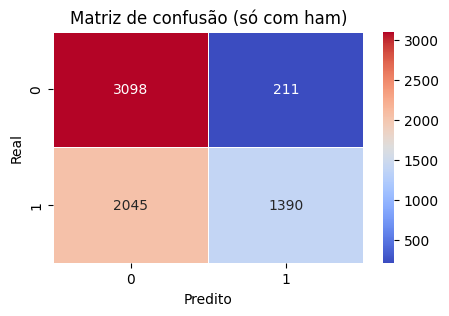

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

#Visualizar a correlação entre matriz usando a mapa de calor
plt.figure(figsize=(5, 3))
sns.heatmap(confusion_matrix(y_test_bin,y_pred), annot=True, cmap='coolwarm', fmt=".0f", linewidths=.5)
plt.title('Matriz de confusão (só com ham)')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

In [ ]:
#https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation